### Download Needed Libraries

In [23]:
!pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=2b49136c9e4852e5d04d840475386060c9064ca924d21db984b7ff0bb9e6614c
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\15\9a\b1\2478e73a520d596fab614693f5cd1beef4ba3db737bed1ac7d
Successfully built sklearn


In [1]:
TEST_DIR = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/OCR/TEST/'
DATA_DIR = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/OCR/DATA/'
TEST_DATA_FILENAME = DATA_DIR + 't10k-images.idx3-ubyte'
TEST_LABELS_FILENAME = DATA_DIR + 't10k-labels.idx1-ubyte'
TRAIN_DATA_FILENAME = DATA_DIR + 'train-images.idx3-ubyte'
TRAIN_LABELS_FILENAME = DATA_DIR + 'train-labels.idx1-ubyte'

In [2]:
def bytes_to_int(byte_data):
    return int.from_bytes(byte_data, 'big')

def read_images(filename, n_max_images=None):
    images = []
    with open(filename, 'rb') as f:
        _ = f.read(4) # magic number
        n_images = bytes_to_int(f.read(4))
        if n_max_images:
            n_images = n_max_images
            
        n_rows = bytes_to_int(f.read(4))
        n_columns = bytes_to_int(f.read(4))
        for image_idx in range(n_images):
            image = []
            for row_idx in range(n_rows):
                row = []
                for col_idx in range(n_columns):
                    pixel = bytes_to_int(f.read(1))
#                     pixel = f.read(1)
                    row.append(pixel)
                image.append(row)
            images.append(image)
    return images

def read_labels(filename, n_max_labels=None):
    labels = []
    with open(filename, 'rb') as f:
        _ = f.read(4)
        n_labels = bytes_to_int(f.read(4))
        if n_max_labels:
            n_labels = n_max_labels
        for label_idx in range(n_labels):
            label = bytes_to_int(f.read(1))
#             label = f.read(1)
            labels.append(label)
    return labels

# converts a two dimentional list into one dimentional
def flatten_list(l):
    return [pixel for sublist in l for pixel in sublist]

def extract_features(X):
    return [flatten_list(sample) for sample in X]


### Approach 1. Implemented KNN

In [3]:
X_train = read_images(TRAIN_DATA_FILENAME, 3000) # list of images
y_train = read_labels(TRAIN_LABELS_FILENAME, 3000)
X_test = read_images(TEST_DATA_FILENAME, 100)
y_test = read_labels(TEST_LABELS_FILENAME, 100)

X_train = extract_features(X_train)
X_test = extract_features(X_test)

In [4]:
def dist(x, y):
    return sum([(x_i - y_i)**2 for x_i, y_i in zip(x, y)])**(0.5)

def get_training_distances_for_test_samples(X_train, test_sample):
    return [dist(train_sample, test_sample) for train_sample in X_train]

def get_most_frequent_element(l):
    return max(l, key = l.count)

def knn(X_train, y_train, X_test, k=3):
    y_pred = []
    for sample in X_test:
        training_distances = get_training_distances_for_test_samples(X_train, sample)
        sorted_distance_indices = [ 
            pair[0]
            for pair in sorted(enumerate(training_distances), key = lambda x : x[1])
        ]
        candidates = [
            y_train[idx] for idx in sorted_distance_indices[:k]
        ]
        top_candidate = get_most_frequent_element(candidates)
#         print(sorted_distance_indices)
        y_pred.append(top_candidate)
    return y_pred
    

In [5]:
y_pred = knn(X_train, y_train, X_test, 3)

### Accuracy For Above Approach

In [10]:
accuracy = sum([y_pred_i == y_test_i for y_pred_i, y_test_i in zip(y_pred, y_test)])/len(y_test)
print(accuracy)

0.94


### Test On Some Handwritten Data


### To use this cell with 'TEST' dataset:
        1. Open the file present in 'TEST' folder in 'MS Paint'.
        2. Draw using marker with background as black and digit in white to match the trained dataset for now.
        3. Save the file.
        4. Run this cell and check the accuracy.
 
 Follow the above procedure to check accuracy for various digits and check model performance on distorted images. 
 

### To use TEST_1 AND TEST_2 dataset, change the 'TEST_DIR' below and 'no_of_plots = count(test images)'

------------------------------------------------
Expected:  MY_TEST.png
Predicted: [5]
------------------------------------------------


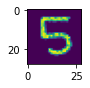

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
def test_images(test_img_dir):
    for entry in os.scandir(test_img_dir):
        image_path = entry.path
        image_name = image_path.split('/')[-1]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
#         image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image,(28,28))
#         image = cv2.bitwise_not(image)
        print("------------------------------------------------")
        fig = plt.figure(image_name, figsize=(1,1))
        plt.imshow(image)
        if image.shape[0]!=784:
            image = flatten_list(image)
        y_pred = knn(X_train, y_train, [image], 3)
        print("Expected:  {}".format(image_name))
        print("Predicted: {}".format(y_pred))
        print("------------------------------------------------")
        

TEST_DIR = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/OCR/TEST/'
test_images(TEST_DIR)

### Approach 2: Using Sklearn and comparing Accuracy

In [12]:
X_train = read_images(TRAIN_DATA_FILENAME, 5000) # list of images
y_train = read_labels(TRAIN_LABELS_FILENAME, 5000)
X_test = read_images(TEST_DATA_FILENAME, 100)
y_test = read_labels(TEST_LABELS_FILENAME, 100)

X_train = extract_features(X_train)
X_test = extract_features(X_test)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
# create an instance of the classifier
knn_default = KNeighborsClassifier()
# fit the model and perform cross validation
knn_default = KNeighborsClassifier()
cv_scores = cross_val_score(knn_default, X_train, y_train, cv=5, scoring="accuracy")
# take the average of the scores of different folds
final_score_default = np.mean(cv_scores)
print("Accuracy with defaul KNN:", final_score_default)

Accuracy with defaul KNN: 0.9276


In [14]:
parameters = {'n_neighbors':list(range(4,7)), 'weights': ['uniform', 'distance']}

from sklearn.model_selection import GridSearchCV
# create an instance of the knn classifier
knn_grid_tuned = KNeighborsClassifier()
# create an instance of grid search with the above parameters
grid_search = GridSearchCV(knn_grid_tuned, parameters, cv=2, scoring='accuracy', return_train_score=True, verbose=10)
# fit the grid search with training set
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START n_neighbors=4, weights=uniform..............................
[CV 1/2; 1/6] END ............n_neighbors=4, weights=uniform; total time=   0.4s
[CV 2/2; 1/6] START n_neighbors=4, weights=uniform..............................
[CV 2/2; 1/6] END ............n_neighbors=4, weights=uniform; total time=   0.4s
[CV 1/2; 2/6] START n_neighbors=4, weights=distance.............................
[CV 1/2; 2/6] END ...........n_neighbors=4, weights=distance; total time=   0.3s
[CV 2/2; 2/6] START n_neighbors=4, weights=distance.............................
[CV 2/2; 2/6] END ...........n_neighbors=4, weights=distance; total time=   0.3s
[CV 1/2; 3/6] START n_neighbors=5, weights=uniform..............................
[CV 1/2; 3/6] END ............n_neighbors=5, weights=uniform; total time=   0.4s
[CV 2/2; 3/6] START n_neighbors=5, weights=uniform..............................
[CV 2/2; 3/6] END ............n_neighbors=5, weig

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 5, 6],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [15]:
# retrieve the best estimator
knn_tuned = grid_search.best_estimator_

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_tuned.predict(X_test))

0.94

### Test On Some Handwritten Data

### To use this cell with 'TEST' dataset:
        1. Open the file present in 'TEST' folder in 'MS Paint'.
        2. Draw using marker with background as black and digit in white to match the trained dataset for now.
        3. Save the file.
        4. Run this cell and check the accuracy.
 
 Follow the above procedure to check accuracy for various digits and check model performance on distorted images. 
 

### To use TEST_1 AND TEST_2 dataset, change the 'TEST_DIR' below and 'no_of_plots = count(test images)'

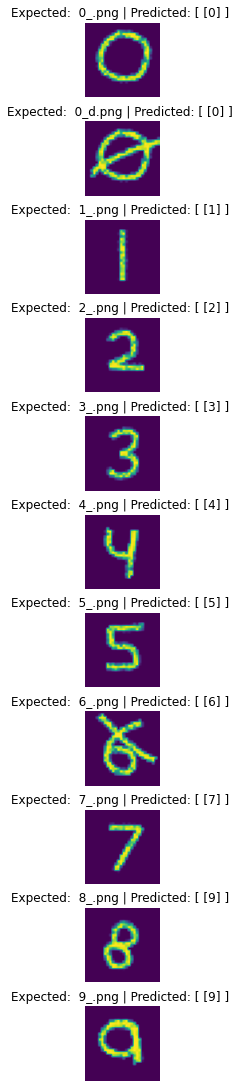

In [38]:
import os
import matplotlib.pyplot as plt
import cv2

def test_images_neural_network(test_img_dir):
    no_of_plots = 11
    plot = 0
    fig, ax = plt.subplots(no_of_plots, 1, figsize=(15,15), constrained_layout = True)
    for entry in os.scandir(test_img_dir):
        image_path = entry.path
        image_name = image_path.split('/')[-1]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        title = ""
        if image is None:
            title = "!! No Image !!"
        else:
            image = cv2.resize(image,(28,28))
            if image.shape[0]!=784:
                image = flatten_list(image)
            image =  np.array([image])
            # Training on various algo's
            y_pred = knn_tuned.predict(image)            
            title = "Expected:  {} | Predicted: [ {} ] ".format(image_name, y_pred)
        plt.axis('off')
        image = np.reshape(image, (28,28))
        ax[plot].imshow(image)
        ax[plot].set_title(title)
        ax[plot].set_axis_off()
        plot += 1

TEST_DIR = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/OCR/TEST_1/'
test_images_neural_network(TEST_DIR)



### Approach 3: Using Neural Network - Tensor FLow

In [21]:
X_train = read_images(TRAIN_DATA_FILENAME, 2000) # list of images
y_train = read_labels(TRAIN_LABELS_FILENAME, 2000)
X_test = read_images(TEST_DATA_FILENAME, 100)
y_test = read_labels(TEST_LABELS_FILENAME, 100)

X_train = extract_features(X_train)
X_test = extract_features(X_test)

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### Tensor Flow Model

In [24]:
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        tf.keras.Input(shape=(784,)),
        Dense(25, activation='relu', name = 'layer1'),
        Dense(15, activation='relu', name = 'layer2'),
        Dense(10, activation='linear', name = 'layer3')
    ], name = "my_model" 
)

model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                19625     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 10)                160       
                                                                 
Total params: 20,175
Trainable params: 20,175
Non-trainable params: 0
_________________________________________________________________


In [25]:
[layer1, layer2, layer3] = model.layers
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


In [26]:
model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=40
)

Epoch 1/40
63/63 [==============================] - 1s 2ms/step - loss: 11.2531
Epoch 2/40
63/63 [==============================] - 0s 2ms/step - loss: 2.2486
Epoch 3/40
63/63 [==============================] - 0s 2ms/step - loss: 2.0771
Epoch 4/40
63/63 [==============================] - 0s 2ms/step - loss: 1.9005
Epoch 5/40
63/63 [==============================] - 0s 2ms/step - loss: 1.7592
Epoch 6/40
63/63 [==============================] - 0s 2ms/step - loss: 1.6007
Epoch 7/40
63/63 [==============================] - 0s 2ms/step - loss: 1.4423
Epoch 8/40
63/63 [==============================] - 0s 2ms/step - loss: 1.3554
Epoch 9/40
63/63 [==============================] - 0s 2ms/step - loss: 1.2779
Epoch 10/40
63/63 [==============================] - 0s 2ms/step - loss: 1.2554
Epoch 11/40
63/63 [==============================] - 0s 2ms/step - loss: 1.1991
Epoch 12/40
63/63 [==============================] - 0s 2ms/step - loss: 1.1117
Epoch 13/40
63/63 [=============================

### Testing and getting accuracy

In [27]:
import numpy as np
def neural_network_predict(X_test):
    y_pred_p = model.predict(X_test)
    y_pred = tf.nn.softmax(y_pred_p)
    y_hat = []
    for i in y_pred:
        y_hat.append(np.argmax(i))
    return y_hat

y_pred = neural_network_predict(X_test)
accuracy = sum([y_pred_i == y_test_i for y_pred_i, y_test_i in zip(y_pred, y_test)])/len(y_test)
print(accuracy)

4/4 [==============================] - 0s 2ms/step
0.82


### Testing on handwritten data
Here all three model have been simultaneously executed on the same image data and predicted value in shown in title of image.


1/1 [==============================] - 0s 21ms/step


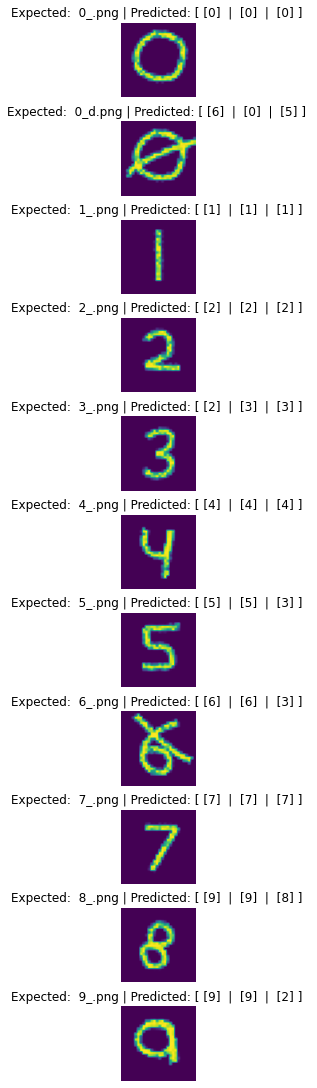

In [35]:
import os
import matplotlib.pyplot as plt
import cv2
def test_images_neural_network(test_img_dir):
    no_of_plots = 11
    plot = 0
    fig, ax = plt.subplots(no_of_plots, 1, figsize=(15,15), constrained_layout = True)
    for entry in os.scandir(test_img_dir):
        image_path = entry.path
        image_name = image_path.split('/')[-1]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        title = ""
        if image is None:
            title = "!! No Image !!"
        else:
            image = cv2.resize(image,(28,28))
            if image.shape[0]!=784:
                image = flatten_list(image)
            image =  np.array([image])
            # Training on various algo's
            
            y_pred_algo_1 = knn(X_train, y_train, image, 3)
            y_pred_algo_2 = knn_tuned.predict(image)
            
            y_pred = model.predict(image)
            # applying softmax function
            y_pred_p = tf.nn.softmax(y_pred)
            y_pred_algo_3 = np.argmax(y_pred_p)
            title = "Expected:  {} | Predicted: [ {}  |  {}  |  [{}] ] ".format(image_name, y_pred_algo_1, y_pred_algo_2, y_pred_algo_3)
        plt.axis('off')
        image = np.reshape(image, (28,28))
        ax[plot].imshow(image)
        ax[plot].set_title(title)
        ax[plot].set_axis_off()
        plot += 1

TEST_DIR = 'C:/Users/HP/OneDrive/Desktop/MACHINE LEARNING PROJECTS/OCR/TEST_1/'
test_images_neural_network(TEST_DIR)